El objetivo de este desafío es entrenar un modelo de ensamble que permita predecir
tempranamente si un cliente renunciará a la compañía, además de poder explicar cuál o
cuáles son las características que más incidencia tienen en la separación de clientes con y
sin renuncia. Para esto deberás aplicar los conceptos y herramientas aprendidas hasta
ahora.
La muestra con la que se trabajará es un archivo llamado telecom_churn.csv, que contiene
los siguientes atributos asociados a clientes:
1. Churn (Variable objetivo): valor 1 si el cliente canceló el servicio, 0 si no
2. AccountWeeks: número de semanas que el cliente ha tenido activa la cuenta
3. ContractRenewal: toma el valor 1 si el cliente ha renovado recientemente el contrato,
0 en caso contrario
4. DataPlan: valor 1 si el cliente tiene plan de datos, 0 en caso contrario
5. DataUsage: Gigabytes de uso mensual de datos
6. CustServCalls: número de llamadas al servicio de atención al cliente
7. DayMins: promedio de minutos diurnos al mes
8. DayCalls: número medio de llamadas diurnas
9. MonthlyCharge: factura mensual media
10. OverageFee: mayor cuota de exceso en los últimos 12 meses
11. RoamMin: minutos de Roaming

In [1]:
# Librerias 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import math

# Preprocesamiento y Selección de Modelos 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
import util_bagging as ubagging

# Modelos de Machine Learning 
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text, export_graphviz
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier

# Métricas de Evaluación para problemas de Clasificacion
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
#cargando dataset de business
df = pd.read_csv('telecom_churn.csv')

# Ver primeras filas
print("Primeras 5 filas del dataset:")
display(df.head())

# Información: tipos de dato y valores nulos
print("\nInformación del dataset:")
df.info()

Primeras 5 filas del dataset:


,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1



Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


## No hay valores nulos.

In [3]:
df.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


In [4]:
#Verificacion de los tipo de datos en columnas.
df.dtypes

Churn                int64
AccountWeeks         int64
ContractRenewal      int64
DataPlan             int64
DataUsage          float64
CustServCalls        int64
DayMins            float64
DayCalls             int64
MonthlyCharge      float64
OverageFee         float64
RoamMins           float64
dtype: object

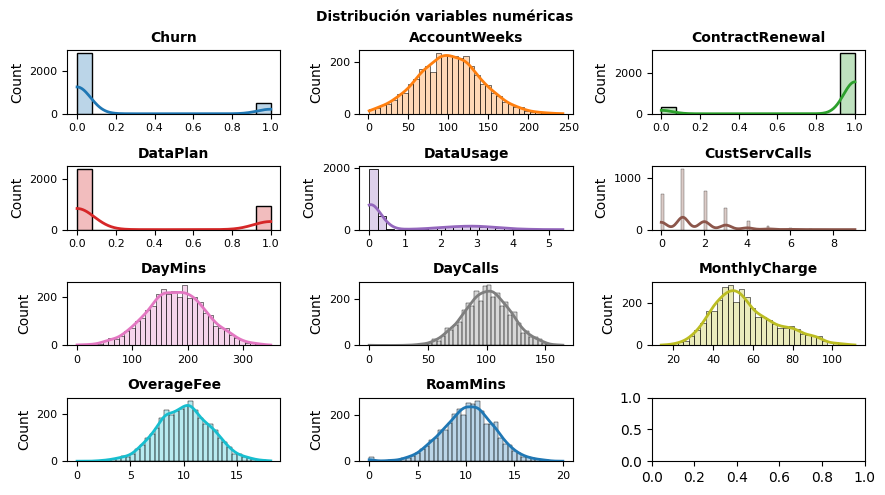

In [5]:
# Gráfico de distribución para cada variable numérica
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(9, 5))
axes = axes.flat
columnas_numeric = df.select_dtypes(include=['float64', 'int']).columns

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = df,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 10, fontweight = "bold")
    axes[i].tick_params(labelsize = 8)
    axes[i].set_xlabel("")


    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

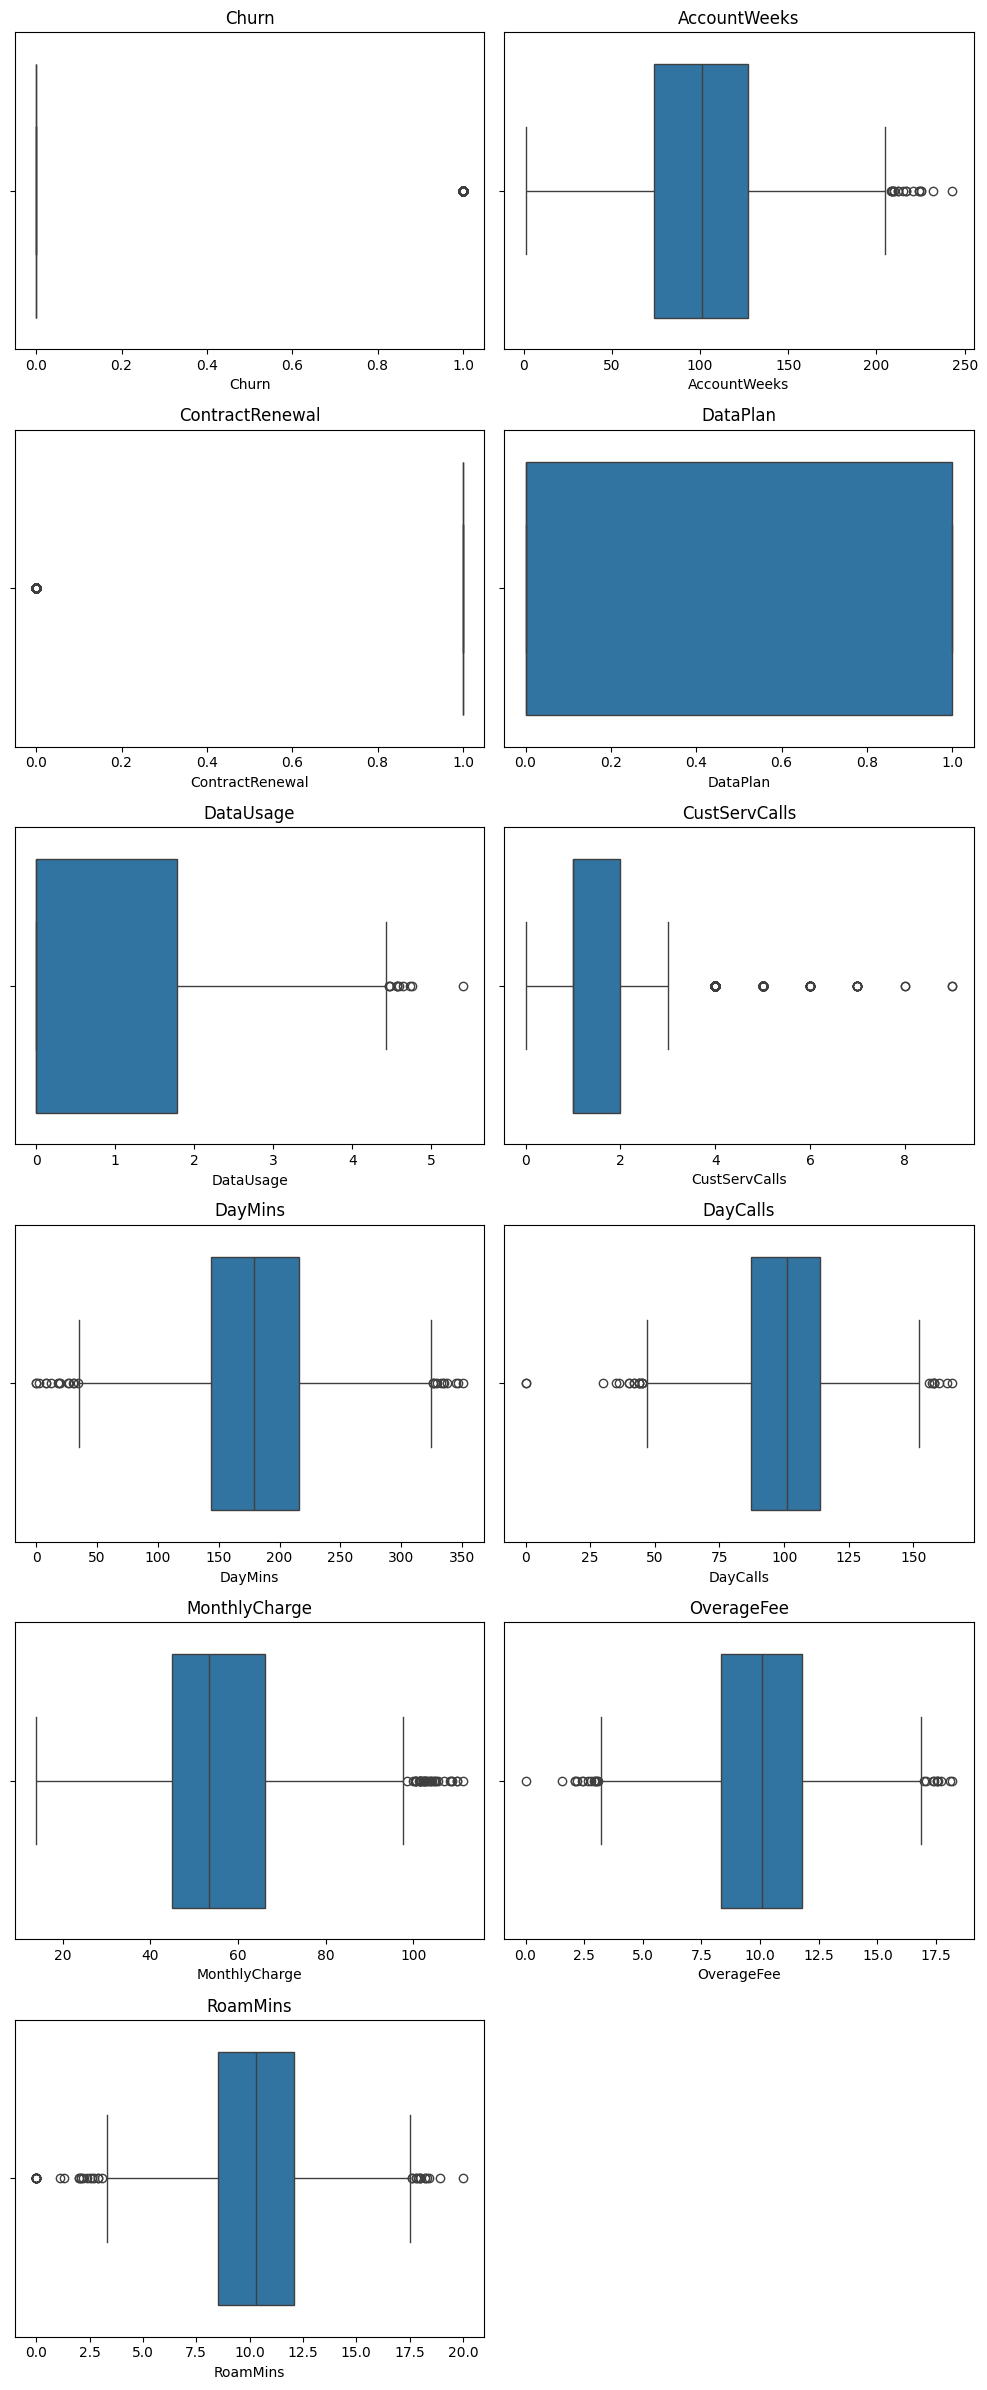

In [6]:
# Verificando que sean solo columnas numéricas
numericas = df.select_dtypes(include=["int64", "float64"])

# Definir layout: 3 columnas por fila
n_columnas = 2
n_graficos = len(numericas.columns)
n_filas = math.ceil(n_graficos / n_columnas)

# Crear boxplots
plt.figure(figsize=(5 * n_columnas, 4 * n_filas))
for i, col in enumerate(numericas.columns, 1):
    plt.subplot(n_filas, n_columnas, i)
    sns.boxplot(x=df[col])
    plt.title(col)

plt.tight_layout()
plt.show()


2. CORRELACIÓNES:


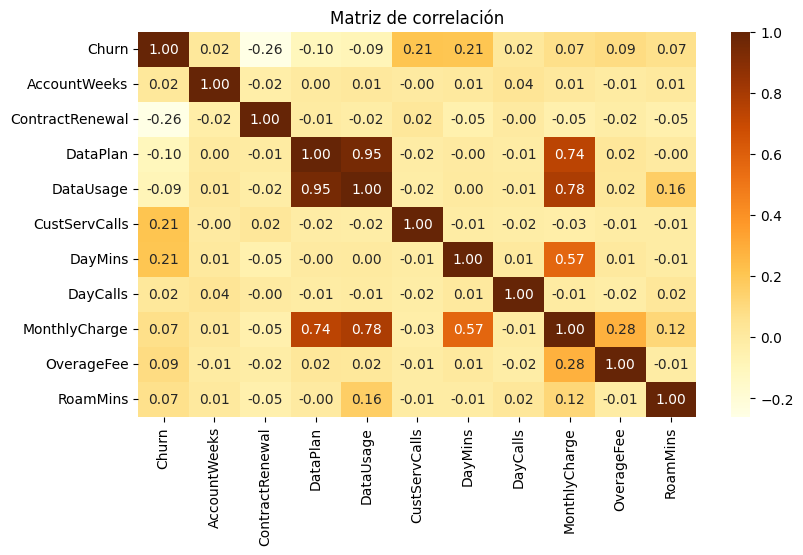

In [7]:
#Correlacion entre variables
# Correlación después de añadir volumen
print("\n2. CORRELACIÓNES:")


plt.figure(figsize=(9, 5))
sns.heatmap(df[numericas.columns].corr(), annot=True, cmap='YlOrBr', fmt=".2f")
plt.title("Matriz de correlación")
plt.show()

## División de los datos en entrenamiento y prueba.

In [8]:
# Definir X e y
X = df.drop(columns = ['Churn'])

y = df['Churn']

In [9]:
RANDOM_STATE = 202310

# División de los datos en train y test 75/25
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state = 123)

In [10]:
X_train.shape, X_test.shape

((2666, 10), (667, 10))

## Arbol de decision

In [11]:
model1 = DecisionTreeClassifier()

# training
model1.fit(X_train, y_train)

# prediction para conjunto de test
y_pred_arbol = model1.predict(X_test)

# prediction para conjunto de train
y_pred_arbol_train = model1.predict(X_train)


#probabilidad arbol (test)
y_prob_arbol = model1.predict_proba(X_test)[:, 1]

#probabilidad arbol (train)
y_prob_arbol_train = model1.predict_proba(X_train)[:, 1]

### Funcion para las métricas

In [12]:
def metricas(y_test, y_pred, y_pred_proba=None):
    
    from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix
    """
    Calcula métricas de clasificación
    
    Parameters:
    y_test: array con valores reales
    y_pred: array con predicciones (clases)
    y_pred_proba: array con probabilidades de clase positiva (opcional para ROC AUC)
    """
    
    # Cálculo de métricas básicas
    metrics = {
        "Accuracy": accuracy_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred)
    }
    
    # ROC AUC solo si se proporcionan probabilidades
    if y_pred_proba is not None:
        try:
            metrics["ROC AUC"] = roc_auc_score(y_test, y_pred_proba)
        except Exception as e:
            print(f"Error calculando ROC AUC: {e}")
            metrics["ROC AUC"] = None
    
    # Convertir a DataFrame
    metrics_df = pd.DataFrame({
        "Métrica": list(metrics.keys()), 
        "Valor": list(metrics.values())
    })
    
    # Imprimir resultados
    print("=" * 50)
    print("MÉTRICAS DEL MODELO (CLASE 1)")
    print("=" * 50)
    print(metrics_df.round(4))
    print("=" * 50)
    
    return metrics_df

In [13]:
#Se calculas y guardan las metricas de los 3 modelos optimizados
print('ÁRBOL DE DECISIÓN (TEST)')
print(classification_report(y_test, y_pred_arbol))
metricas_arbol =  metricas(y_test,y_pred_arbol, y_prob_arbol) #modelo arbol datos test

print('ÁRBOL DE DECISIÓN (TRAIN)')
print(classification_report(y_train, y_pred_arbol_train))
metricas_arbol_train =  metricas(y_train, y_pred_arbol_train, y_prob_arbol_train) #modelo arbol datos train



ÁRBOL DE DECISIÓN (TEST)
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       572
           1       0.56      0.64      0.60        95

    accuracy                           0.88       667
   macro avg       0.75      0.78      0.76       667
weighted avg       0.89      0.88      0.88       667

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.8786
1   F1-score  0.6010
2  Precision  0.5648
3     Recall  0.6421
4    ROC AUC  0.7800
ÁRBOL DE DECISIÓN (TRAIN)
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2278
           1       1.00      1.00      1.00       388

    accuracy                           1.00      2666
   macro avg       1.00      1.00      1.00      2666
weighted avg       1.00      1.00      1.00      2666

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica  Valor
0   Accuracy    1.0
1   F1-score    1.0
2  Precision    1.0
3     Recall    1.0
4    ROC 

El modelo presenta overfitting, y las métricas de la clase 1 (las personas que se van) no son buenas.

## Gridsearch + Árbol de Decision (seleccion mejor hiperparámetros (Gridsearch))

In [14]:
# 1. Definir la grilla de hiperparámetros a probar
params = {'max_depth': [5, 10, 15, 20, 25],
          'min_samples_leaf':  [0.01, 0.02, 0.03, 0.04]}


# 2. Configurar GridSearchCV y Ejecutar la búsqueda
# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search = GridSearchCV(DecisionTreeClassifier(), params, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y su puntaje
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Obtener el mejor modelo de arbol con los mejores hiperparámetros
best_arbol = grid_search.best_estimator_

#Guardar resultados en variables
#Datos test
y_pred_arbol_grid = best_arbol.predict(X_test)
y_prob_arbol_grid =best_arbol.predict_proba(X_test)[:, 1]

#Datos train
y_pred_arbol_grid_train = best_arbol.predict(X_train)
y_prob_arbol_grid_train =best_arbol.predict_proba(X_train)[:, 1]

# Resultados
print(f"Mejores hiperparámetros: {best_params}")
print(f"Accuracy del modelo con los mejores hiperparámetros:: {best_score:.2f}")

Mejores hiperparámetros: {'max_depth': 10, 'min_samples_leaf': 0.01}
Accuracy del modelo con los mejores hiperparámetros:: 0.92


In [15]:
#Se calculas y guardan las metricas de los 3 modelos optimizados
print('ÁRBOL DE DECISIÓN GRIDSEARCH (TEST)')
print(classification_report(y_test, y_pred_arbol_grid))
metricas_arbol =  metricas(y_test,y_pred_arbol_grid, y_prob_arbol_grid) #modelo arbol datos test

print('ÁRBOL DE DECISIÓN GRIDSEARCH (TRAIN)')
print(classification_report(y_train, y_pred_arbol_grid_train))
metricas_arbol_train =  metricas(y_train, y_pred_arbol_grid_train, y_prob_arbol_grid_train) #modelo arbol datos train

ÁRBOL DE DECISIÓN GRIDSEARCH (TEST)
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       572
           1       0.88      0.54      0.67        95

    accuracy                           0.92       667
   macro avg       0.90      0.76      0.81       667
weighted avg       0.92      0.92      0.92       667

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.9235
1   F1-score  0.6667
2  Precision  0.8793
3     Recall  0.5368
4    ROC AUC  0.8976
ÁRBOL DE DECISIÓN GRIDSEARCH (TRAIN)
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      2278
           1       0.91      0.60      0.72       388

    accuracy                           0.93      2666
   macro avg       0.92      0.79      0.84      2666
weighted avg       0.93      0.93      0.93      2666

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.9321
1   F1-score  0.7185
2  Precision  0.9059
3  

Limitando la profundidad se soluciona el overfitting, y las metricas del modelo mejoran mucho con gridsearch. El modelo es muy bueno para identificar los clientes que no renuncian (93% de las veces acierta). La métrica mas débil es recall, esto quiere decir que solo las mitad de los clientes que realmente abandonan son identificados por el modelo.

## Balanceo de clases (SMOTE) y Bagging

In [16]:
#Inicialización smote
sm = SMOTE(random_state=42)

#Balanceo de clases
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

In [17]:
len(X_train)

2666

In [18]:
len(X_train_sm)

4556

In [19]:
# se crea el modelo usando 200 estimadores (árboles de decisión)
bagg1_model = BaggingClassifier(n_estimators=200, random_state=200)
bagg1_model.fit(X_train_sm, y_train_sm)

# mostrar datos de cada modelo que componen el ensamble
for idx, i in enumerate(bagg1_model.estimators_):
  print(f'{idx+1} - Tipo: {type(i)}, críterio: {i.criterion}, random_state: {i.random_state}')

1 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 135495479
2 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 440919658
3 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1097829529
4 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1413208146
5 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1004322165
6 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1200242708
7 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1551507283
8 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 2106254737
9 - Tipo: <class 'sklearn.tree._classes.DecisionTreeClassifier'>, críterio: gini, random_state: 1502219576
10 - Tipo: <class 'sklearn.tree._classe

In [20]:
#Guardar resultados en variables
#Datos test
y_pred_bagg1 = bagg1_model.predict(X_test)
y_prob_bagg1 = bagg1_model.predict_proba(X_test)[:, 1]

#Se calculas y guardan las metricas de los 3 modelos optimizados
print('Bagging y Balanceo de clases (TEST)')
metricas_bagg1 =  metricas(y_test,y_pred_bagg1, y_prob_bagg1) #modelo arbol datos test

Bagging y Balanceo de clases (TEST)
MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.8996
1   F1-score  0.6912
2  Precision  0.6148
3     Recall  0.7895
4    ROC AUC  0.9018


In [21]:
print(classification_report(y_test, y_pred_bagg1))

              precision    recall  f1-score   support

           0       0.96      0.92      0.94       572
           1       0.61      0.79      0.69        95

    accuracy                           0.90       667
   macro avg       0.79      0.85      0.82       667
weighted avg       0.91      0.90      0.90       667



El modelo Bagging sigue siendo bueno. Mejora el recall, pero la precisión disminuye; esto quiere decir que, de los clientes que predice que abandonan, solo un 61% realmente lo hace.

## Bagging Heterogeneo

In [22]:
# Como se utilizaran SVM y Regresion logística se escalarán los datos.
scaler = StandardScaler()

# Aplicar StandardScaler a a datos train
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index  # Mantener los índices originales si los hay
)

# Aplicar StandardScaler a datos test
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index  # Mantener los índices originales si los hay
)

In [23]:
estimadores = [
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    SVC(kernel='sigmoid', C=2.3),
    LogisticRegression(max_iter=10000)
]

lst_estimadores, result1, y_pred_bagg_het, idx_oob = ubagging.bagging_het(X_train_scaled, y_train, 200, estimadores, X_test_scaled)

In [24]:
# métricas
print(classification_report(y_test, y_pred_bagg_het))

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       572
           1       0.62      0.16      0.25        95

    accuracy                           0.87       667
   macro avg       0.75      0.57      0.59       667
weighted avg       0.84      0.87      0.83       667



### Bagging con calibrado de modelos

In [25]:
###
# ponderación  para cada clasificador
###

# DecisionTreeClassifier()            -> (50%)
# SVC(kernel='rbf', C=0.2)            -> (17%)
# SVC(kernel='sigmoid', C=2.3)            -> (17%)
# LogisticRegression(max_iter=10000)  -> (17%)

estimadores = [
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    DecisionTreeClassifier(),
    SVC(kernel='rbf', C=0.2),
    SVC(kernel='sigmoid', C=2.3),
    LogisticRegression(max_iter=10000)
]

lst_estimadores, result1, yhat, idx_oob = ubagging.bagging_het(X_train_scaled, y_train, 200, estimadores, X_test_scaled)

In [26]:
# métricas
print(classification_report(y_test, yhat))

              precision    recall  f1-score   support

           0       0.90      0.99      0.94       572
           1       0.81      0.32      0.45        95

    accuracy                           0.89       667
   macro avg       0.85      0.65      0.70       667
weighted avg       0.88      0.89      0.87       667



El modelo bagging heterogeneo no mejora los resultados con respecto al bagging. Lo mas probable que al agregar otros modelos como regression y SVM, no sean tan efectivos para los datos como lo es el arbol de decision.

## Random Forest

In [27]:
rf_model = RandomForestClassifier(n_estimators=45, random_state=RANDOM_STATE, oob_score=True, class_weight='balanced')
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred_rf))

metricas_rf = metricas(y_test,y_pred_rf, y_prob_rf)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       572
           1       0.84      0.65      0.73        95

    accuracy                           0.93       667
   macro avg       0.89      0.82      0.85       667
weighted avg       0.93      0.93      0.93       667

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.9325
1   F1-score  0.7337
2  Precision  0.8378
3     Recall  0.6526
4    ROC AUC  0.8986


### Importancia de los atributos

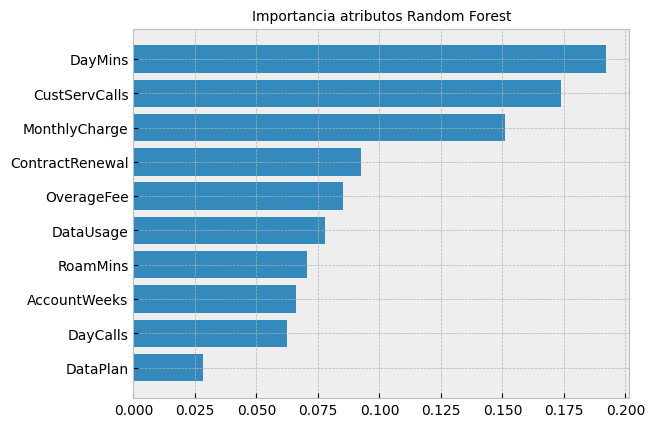

In [28]:
plt.style.use('bmh')

df_importance = pd.DataFrame({
    'atributo': rf_model.feature_names_in_,
    'importancia': rf_model.feature_importances_
}).sort_values(by='importancia', ascending=True)

plt.title('Importancia atributos Random Forest', fontsize=10)
plt.barh(y=df_importance['atributo'], width=df_importance['importancia']);

Random Forest supera a modelos anteriores: mantiene precisión alta (84%) y mejora el recall a 65% para abandonos. Esto significa que identifica mejor los casos reales con menor tasa de error. 

Las 4 variables mas importantes son: DayMins, CustServCalls, MonthlyCharge, Contract Renewal.

In [ ]:
# 1. Definir la grilla de hiperparámetros a probar
params = {'n_estimators': list(range(50, 201, 10)), #50 - 200 con paso de 10 completando 15 valores
            'max_features': ['sqrt', 'log2', None]}


# 2. Configurar GridSearchCV y Ejecutar la búsqueda
# Realizar la búsqueda de hiperparámetros utilizando validación cruzada
grid_search_rf = GridSearchCV(RandomForestClassifier(oob_score=True), param_grid = params, scoring='roc_auc')
grid_search_rf.fit(X_train, y_train)

# Obtener los mejores hiperparámetros y su puntaje
best_rf_params = grid_search_rf.best_params_
best_rf_score = grid_search_rf.best_score_

# Obtener el mejor modelo de arbol con los mejores hiperparámetros
best_rf = grid_search_rf.best_estimator_

#Guardar resultados en variables
#Datos test
y_pred_arbol_grid = best_rf.predict(X_test)
y_prob_arbol_grid =best_rf.predict_proba(X_test)[:, 1]

#Datos train
y_pred_rf_grid_train = best_rf.predict(X_train)
y_prob_rf_grid_train =best_rf.predict_proba(X_train)[:, 1]

# Resultados
print(f"Mejores hiperparámetros: {best_params}")
print(f"Accuracy del modelo con los mejores hiperparámetros:: {best_score:.2f}")

In [38]:
print(classification_report(y_test, y_pred_arbol_grid))

              precision    recall  f1-score   support

           0       0.95      0.98      0.96       572
           1       0.84      0.69      0.76        95

    accuracy                           0.94       667
   macro avg       0.89      0.84      0.86       667
weighted avg       0.93      0.94      0.93       667



In [41]:
metricas_best_rf = metricas(y_test,y_pred_arbol_grid, y_prob_arbol_grid)

MÉTRICAS DEL MODELO (CLASE 1)
     Métrica   Valor
0   Accuracy  0.9370
1   F1-score  0.7586
2  Precision  0.8354
3     Recall  0.6947
4    ROC AUC  0.8951


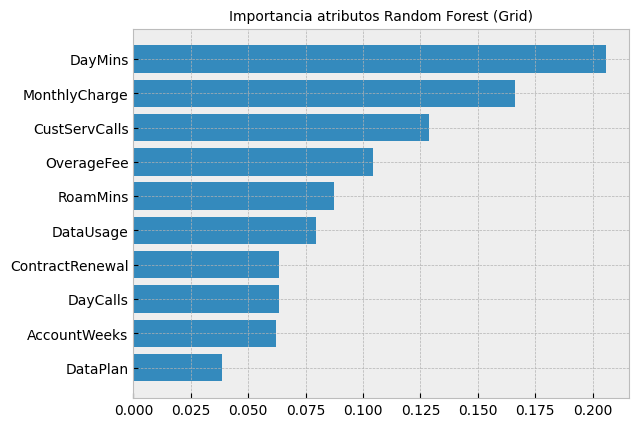

In [47]:
plt.style.use('bmh')

df_importance = pd.DataFrame({
    'atributo': best_rf.feature_names_in_,
    'importancia': best_rf.feature_importances_
}).sort_values(by='importancia', ascending=True)

plt.title('Importancia atributos Random Forest (Grid)', fontsize=10)
plt.barh(y=df_importance['atributo'], width=df_importance['importancia']);

Se mejoran aun más los hiperparametros, aunque la diferencia no es tan significativa, es el mejor modelo en todas las métricas.

## Comparacion de los dos mejores modelos RandomForest y RandomForest con GridSearch

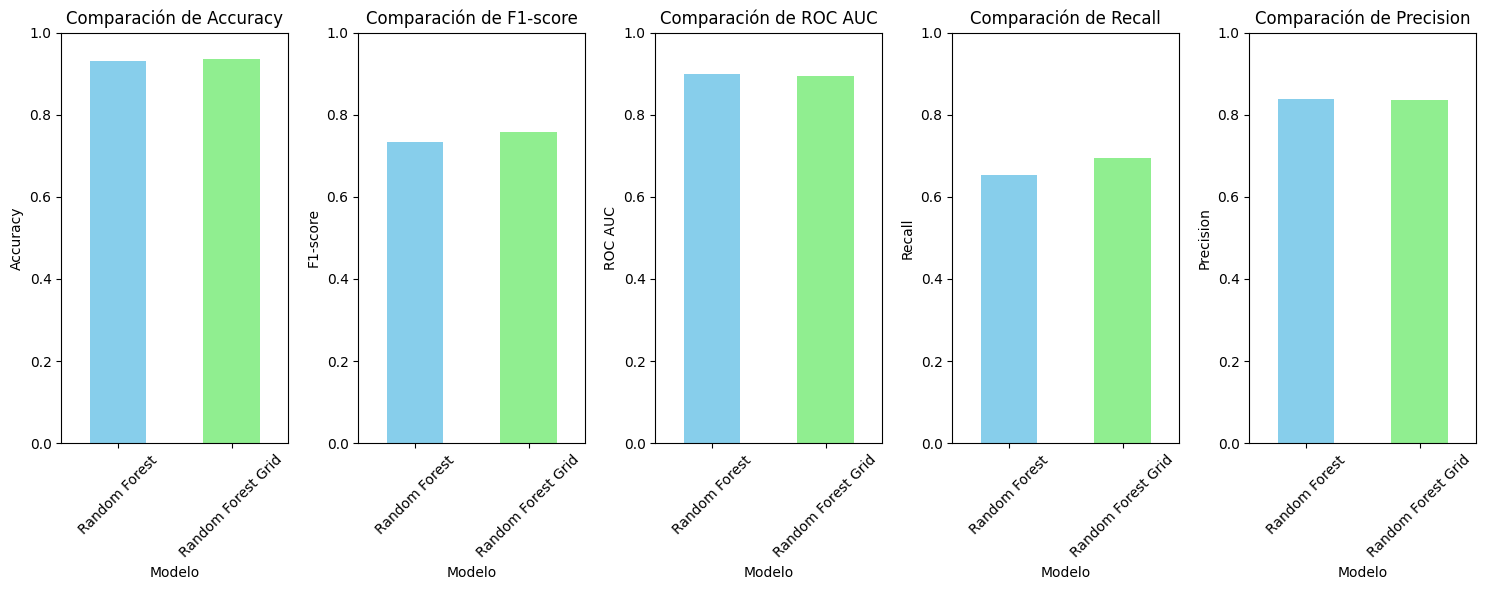

In [44]:
# Configurar el estilo
plt.style.use('default')
sns.set_palette("husl")

# Crear un DataFrame combinado
metricas_combinadas = pd.concat([
    metricas_rf.assign(Modelo='Random Forest'),
    metricas_best_rf.assign(Modelo='Random Forest Grid')
], ignore_index=True)

# Pivotear el DataFrame para tener métricas como columnas
df_pivot = metricas_combinadas.pivot(index='Modelo', columns='Métrica', values='Valor')

# Crear el gráfico de barras comparativo
fig, axes = plt.subplots(1, 5, figsize=(15, 6))

# Gráfico para Accuracy
df_pivot['Accuracy'].plot(kind='bar', ax=axes[0], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[0].set_title('Comparación de Accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=45)

# Gráfico para F1-score
df_pivot['F1-score'].plot(kind='bar', ax=axes[1], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[1].set_title('Comparación de F1-score')
axes[1].set_ylabel('F1-score')
axes[1].set_ylim(0, 1)
axes[1].tick_params(axis='x', rotation=45)

# Gráfico para ROC AUC
df_pivot['ROC AUC'].plot(kind='bar', ax=axes[2], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[2].set_title('Comparación de ROC AUC')
axes[2].set_ylabel('ROC AUC')
axes[2].set_ylim(0, 1)
axes[2].tick_params(axis='x', rotation=45)

# Gráfico para Recall
df_pivot['Recall'].plot(kind='bar', ax=axes[3], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[3].set_title('Comparación de Recall')
axes[3].set_ylabel('Recall')
axes[3].set_ylim(0, 1)
axes[3].tick_params(axis='x', rotation=45)

# Gráfico para Recall
df_pivot['Precision'].plot(kind='bar', ax=axes[4], color=['skyblue', 'lightgreen', 'lightcoral'])
axes[4].set_title('Comparación de Precision')
axes[4].set_ylabel('Precision')
axes[4].set_ylim(0, 1)
axes[4].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [45]:
# Obtener probabilidades
probabilidades = best_rf.predict_proba(X_test)[:, 1]

# Crear DataFrame
df_prob = pd.DataFrame({
    'indice_original': range(len(probabilidades)),
    'probabilidad': probabilidades
})

# Ordenar de mayor a menor
df_prob_ordenado = df_prob.sort_values('probabilidad', ascending=False).reset_index(drop=True)



In [138]:
df_prob_ordenado.head(15)

,indice_original,probabilidad
0,492,1.000000
1,518,0.993333
2,119,0.986667
3,107,0.986667
4,428,0.986667
5,590,0.973333
6,656,0.966667
7,394,0.960000
8,449,0.960000
9,572,0.946667


El indice de los 15 clientes con mayor probabilidad de abandonar la empresa. 

In [144]:
df[492:500]

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
492,1,92,0,0,0.21,2,130.7,113,47.1,13.03,9.4
493,0,129,1,1,1.59,2,119.6,104,60.9,13.94,5.9
494,0,18,1,0,0.00,1,273.6,93,57.0,5.73,8.2
495,0,161,0,0,0.00,2,156.1,114,42.0,9.02,11.1
496,0,93,1,1,2.16,2,178.7,134,67.6,8.93,8.0
497,0,144,1,0,0.00,2,177.5,93,55.0,14.37,11.9
498,1,75,0,0,0.00,4,211.3,61,45.0,5.28,9.7
499,0,95,1,0,0.00,1,175.2,91,51.0,12.22,7.5
